### Assignment 4: TKO_7096-3001 Computer Vision and Sensor Fusion


Goal: develop a RGB-Depth fusion architecture for semantic segmentation based on Fully Convolutional Network (FCN) .


<font color='red'> Deadline: 24.03.2023 at 24:00.

In [ ]:
import os
import numpy as np
import cv2
import glob as glob
from keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
import random

import tensorflow as tf
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

### Load the dataset and Ground-truth###

- Dataset consists of 366 (per modality) images of forest scenes. It is divided into train (200 images), test (100 images) and validation (60 images) datasets.

- Change the size of all images into 256*256.
- Converting the labels into one hot encoding

In [2]:
def load_data(folder_path, size, num_classes):

    depth_files = glob.glob(os.path.join(folder_path, 'depth_color', '*'))
    rgb_folder = glob.glob(folder_path+'/rgb//*')
    label_folder = glob.glob(folder_path+'/GT_color//*')
    depth_data = []
    rgb_data = []
    label_data = []
    for f in depth_files:
        img = cv2.imread(f, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,size, interpolation = cv2.INTER_AREA)
        depth_data.append(img)
    for f in rgb_folder:
        img = cv2.imread(f, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,size, interpolation = cv2.INTER_AREA)
        img_arr = np.array(img)
        rgb_data.append(img_arr)
    for f in label_folder:
        img = cv2.imread(f,cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,size, interpolation = cv2.INTER_NEAREST)
        img[img==35]=1
        img[img==96]=2
        img[img==100]=3
        img[img==150]=4
        img[img==170]=5
        # label_onehot = tf.one_hot(img, num_classes)
        label_onehot = to_categorical(img, num_classes=num_classes)
        label_data.append(label_onehot)
    return np.array(depth_data), np.array(rgb_data), np.array(label_data)

num_classes = 6

train_depth, train_rgb, train_labels = load_data('Dataset/train', (256, 256), num_classes)
val_depth, val_rgb, val_labels = load_data('Dataset/valid', (256, 256), num_classes)
test_depth, test_rgb, test_labels = load_data('Dataset/test', (256, 256), num_classes)

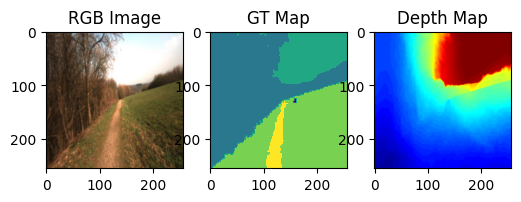

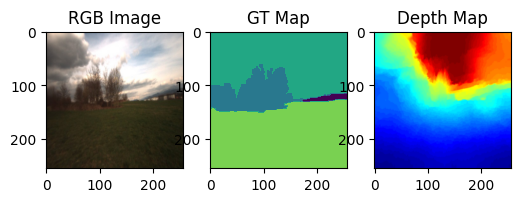

In [3]:
viridis = mpl.colormaps['viridis'].resampled(num_classes)

norm1 = colors.BoundaryNorm(range(num_classes+1), num_classes)

for i in range(3,5):
    label = val_labels[i]
    rgb = val_rgb[i]
    depth = val_depth[i]
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6, 12))
    axs[1].imshow(np.argmax(label,axis=2),cmap=viridis, norm=norm1)
    axs[1].set_title('GT Map')
    axs[0].imshow(rgb)
    axs[0].set_title('RGB Image')
    axs[2].imshow(depth)
    axs[2].set_title('Depth Map')
    plt.show()
test_labels = np.reshape(test_labels,(-1,256*256,6))
val_labels = np.reshape(val_labels,(-1,256*256,6))
train_labels = np.reshape(train_labels,(-1,256*256,6))

 Define a Fully Convolutional Network (FCN) for image segmentaion by fusing RGB and depth images. The network consists of  two sterams which each stream has following layers:

    1. Use the pretrained ResNet50 on imageNet
    2. Two Conv layers with 128 and 256 nodes, respectively. Kernel size (3,3), stride (1,1)
    3. Top of the Conv layers, add dropout layer with 0.2
    4. Concatenate two streams.
    5. Add a transposed convolution layer (Conv2DTranspose)  with Kernel size (64,64), stride (32,32)
    6. Add a reshape layer (tf.keras.layers.Reshape) to reshapes inputs into the given shape.
    7. Add a softmax activation layer
    
 You can find the model summary and structure in the PDF file.


Compile the model with SGD(learning_rate=0.008, decay=1e-6, momentum=0.9) and loss="categorical_crossentropy"

Train the model on the “train” dataset  and “validation”dataset for epochs =10. 

In [ ]:
# Define input shapes
rgb_input_shape = (256, 256, 3)
depth_input_shape = (256, 256, 3)

# Define input layers
rgb_input = tf.keras.Input(shape=rgb_input_shape, name='rgb_input')
depth_input = tf.keras.Input(shape=depth_input_shape, name='depth_input')

# Define the ResNet50 layer for each stream


# Define the ResNet50 layer for each stream
base_resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')

rgb_resnet = tf.keras.Model(inputs=base_resnet.input, outputs=base_resnet.get_layer('conv5_block3_out').output)(rgb_input)
depth_resnet = base_resnet(depth_input)

# rgb_resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', name='rgb_resnet')(rgb_input)
# depth_resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')(depth_input)

# Add two Conv layers with 128 and 256 nodes, respectively, to each stream
rgb_conv1 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(rgb_resnet)
rgb_conv2 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(rgb_conv1)
depth_conv1 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(depth_resnet)
depth_conv2 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(depth_conv1)

# Add dropout layers to each stream
rgb_dropout = tf.keras.layers.Dropout(0.2)(rgb_conv2)
depth_dropout = tf.keras.layers.Dropout(0.2)(depth_conv2)

# Concatenate the two streams
concat = tf.keras.layers.Concatenate()([rgb_dropout, depth_dropout])

# Add a transposed convolution layer
transpose_conv = tf.keras.layers.Conv2DTranspose(6, kernel_size=(64, 64), strides=(32, 32), padding='same')(concat)

# Add a reshape layer
reshape = tf.keras.layers.Reshape((256*256,6))(transpose_conv)

# Add a softmax activation layer
output = tf.keras.layers.Softmax()(reshape)

# Define the model with two inputs and one output
model = tf.keras.models.Model(inputs=[rgb_input, depth_input], outputs=output)

In [7]:
model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.008, decay=1e-6, momentum=0.9),
              loss="categorical_crossentropy", metrics=['accuracy'])

# Train the model on the training data
history = model.fit([train_rgb, train_depth], train_labels, batch_size=2, epochs=10,
                    validation_data=([val_rgb, val_depth], val_labels))

Epoch 1/10


2023-03-21 11:36:37.858872: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 14s 79ms/step - loss: 0.3152 - accuracy: 0.8861 - val_loss: 0.4114 - val_accuracy: 0.8605
Epoch 2/10
100/100 [==============================] - 7s 65ms/step - loss: 0.2854 - accuracy: 0.8957 - val_loss: 0.4423 - val_accuracy: 0.8435
Epoch 3/10
100/100 [==============================] - 7s 66ms/step - loss: 0.2629 - accuracy: 0.9025 - val_loss: 0.4189 - val_accuracy: 0.8539
Epoch 4/10
100/100 [==============================] - 7s 66ms/step - loss: 0.2414 - accuracy: 0.9107 - val_loss: 0.3897 - val_accuracy: 0.8686
Epoch 5/10
100/100 [==============================] - 7s 65ms/step - loss: 0.2324 - accuracy: 0.9130 - val_loss: 0.3629 - val_accuracy: 0.8781
Epoch 6/10
100/100 [==============================] - 7s 65ms/step - loss: 0.2171 - accuracy: 0.9183 - val_loss: 0.4265 - val_accuracy: 0.8591
Epoch 7/10
100/100 [==============================] - 7s 65ms/step - loss: 0.2050 - accuracy: 0.9210 - val_loss: 0.4352 - val_accuracy: 0.8585
Epoch 8/1

 Evaluate the model on the training and test dataset. The results must be shown as 

- Print loss and accuracy of model for  test dataset.

- Predict semantically segmented images  on 5 random example of test dataset.

4/4 - 2s - loss: 0.3912 - accuracy: 0.8746 - 2s/epoch - 575ms/step
Test loss: 0.3911914527416229
Test accuracy: 0.8746408224105835


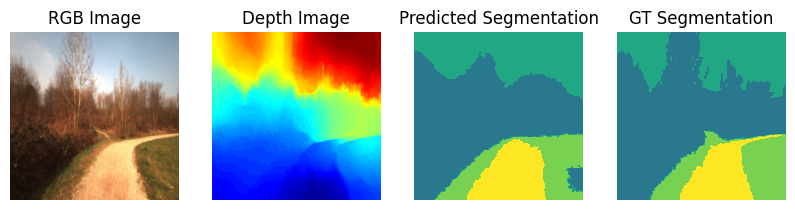

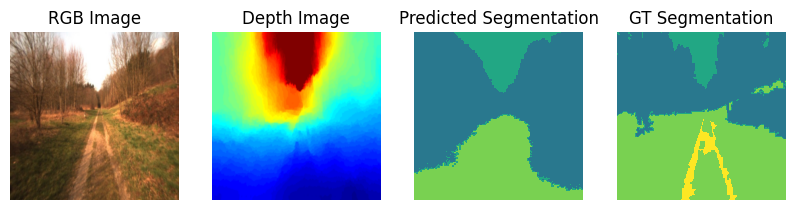

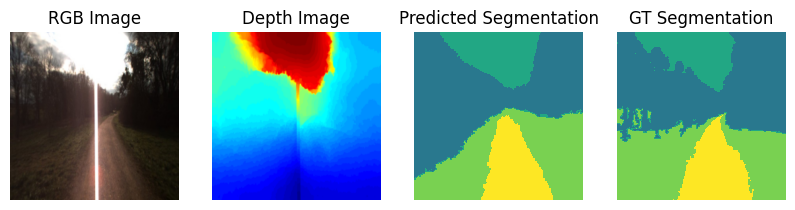

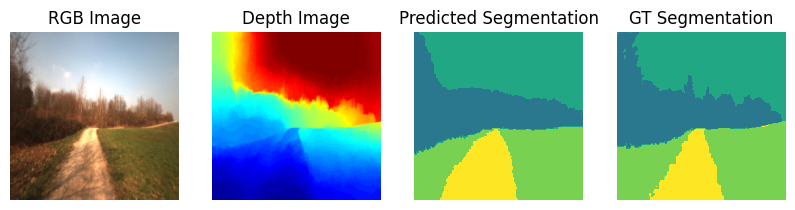

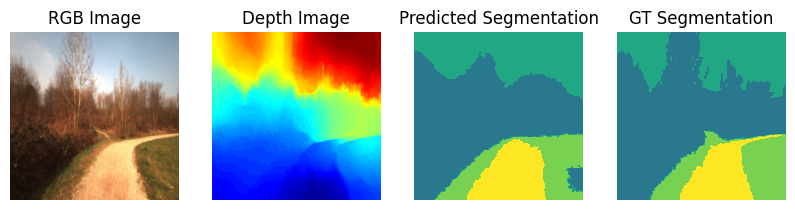

In [8]:
test_loss, test_acc = model.evaluate([test_rgb, test_depth], test_labels, verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

viridis = mpl.colormaps['viridis'].resampled(num_classes)

norm1 = colors.BoundaryNorm(range(num_classes+1), num_classes)

for i in range(5):
    idx = random.randint(0, len(test_rgb) - 1)
    rgb_sample = np.expand_dims(test_rgb[idx], axis=0)
    depth_sample = np.expand_dims(test_depth[idx], axis=0)
    true_label = np.reshape(np.argmax(test_labels[idx], axis=-1),(256,256))
    pred_label =np.reshape(np.argmax(model.predict([rgb_sample, depth_sample], verbose=0)[0], axis=-1),(256,256))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(rgb_sample[0])
    plt.title('RGB Image')
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.imshow(depth_sample[0], cmap='gray')
    plt.title('Depth Image')
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.imshow(pred_label,cmap=viridis, norm=norm1)
    plt.title('Predicted Segmentation')
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.imshow(true_label,cmap=viridis, norm=norm1)
    plt.title('GT Segmentation')
    plt.axis('off')
    plt.show()

### Extra 5 points :

Implement FCNs for each sing modality and compare their accuracy with fusion model. I need the result of the following table in the same notebook. 

In [7]:
# Define input shapes
rgb_input_shape = (256, 256, 3)

# Define input layers
rgb_input = tf.keras.Input(shape=rgb_input_shape, name='rgb_input')

# Define the ResNet50 layer for each stream


# Define the ResNet50 layer for each stream
base_resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')

rgb_resnet = tf.keras.Model(inputs=base_resnet.input, outputs=base_resnet.get_layer('conv5_block3_out').output)(rgb_input)

# rgb_resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', name='rgb_resnet')(rgb_input)
# depth_resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')(depth_input)

# Add two Conv layers with 128 and 256 nodes, respectively, to each stream
rgb_conv1 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(rgb_resnet)
rgb_conv2 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(rgb_conv1)

# Add dropout layers to each stream
rgb_dropout = tf.keras.layers.Dropout(0.2)(rgb_conv2)

# Concatenate the two streams
# concat = tf.keras.layers.Concatenate()([rgb_dropout, depth_dropout])

# Add a transposed convolution layer
transpose_conv = tf.keras.layers.Conv2DTranspose(6, kernel_size=(64, 64), strides=(32, 32), padding='same')(rgb_dropout)

# Add a reshape layer
reshape = tf.keras.layers.Reshape((256*256,6))(transpose_conv)

# Add a softmax activation layer
output = tf.keras.layers.Softmax()(reshape)

# Define the model with two inputs and one output
model = tf.keras.models.Model(inputs=rgb_input, outputs=output)

In [8]:
model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.008, decay=1e-6, momentum=0.9),
              loss="categorical_crossentropy", metrics=['accuracy'])

# Train the model on the training data
history = model.fit(train_rgb, train_labels, batch_size=2, epochs=10,
                    validation_data=(val_rgb, val_labels))

Epoch 1/10


2023-03-20 16:16:20.231979: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 9s 54ms/step - loss: 1.3789 - accuracy: 0.4414 - val_loss: 0.9592 - val_accuracy: 0.7031
Epoch 2/10
100/100 [==============================] - 4s 45ms/step - loss: 0.6745 - accuracy: 0.7593 - val_loss: 0.5791 - val_accuracy: 0.7932
Epoch 3/10
100/100 [==============================] - 4s 45ms/step - loss: 0.4682 - accuracy: 0.8208 - val_loss: 0.4244 - val_accuracy: 0.8499
Epoch 4/10
100/100 [==============================] - 4s 45ms/step - loss: 0.3581 - accuracy: 0.8707 - val_loss: 0.3706 - val_accuracy: 0.8646
Epoch 5/10
100/100 [==============================] - 4s 45ms/step - loss: 0.3017 - accuracy: 0.8915 - val_loss: 0.3297 - val_accuracy: 0.8790
Epoch 6/10
100/100 [==============================] - 5s 45ms/step - loss: 0.2681 - accuracy: 0.9021 - val_loss: 0.3055 - val_accuracy: 0.8876
Epoch 7/10
100/100 [==============================] - 4s 45ms/step - loss: 0.2494 - accuracy: 0.9089 - val_loss: 0.3022 - val_accuracy: 0.8909
Epoch 8/10

4/4 - 1s - loss: 0.2605 - accuracy: 0.9090 - 1s/epoch - 276ms/step
Test loss: 0.2604862451553345
Test accuracy: 0.9089811444282532


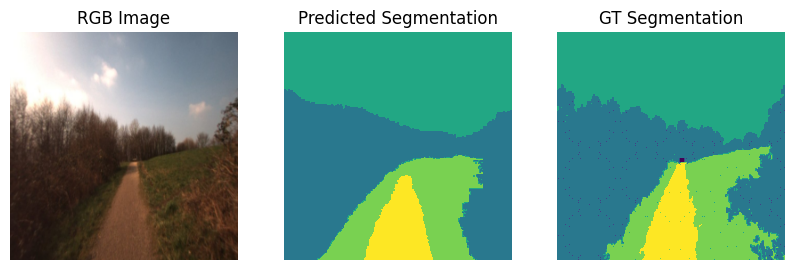

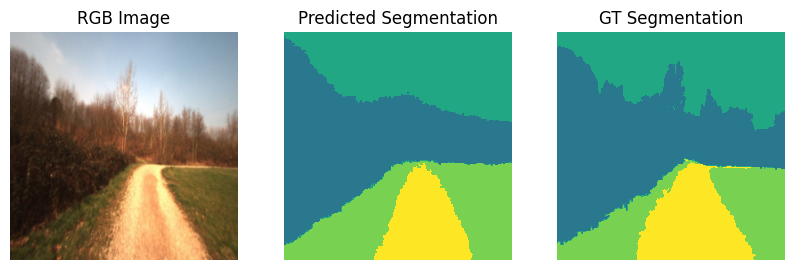

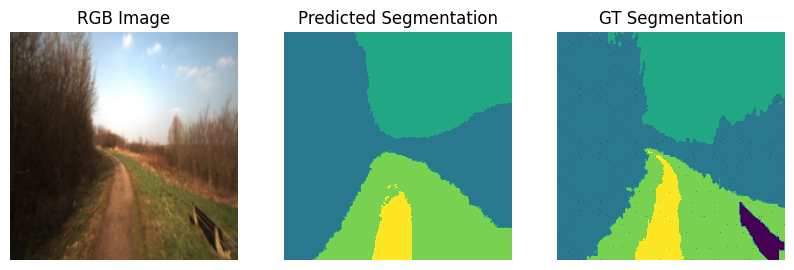

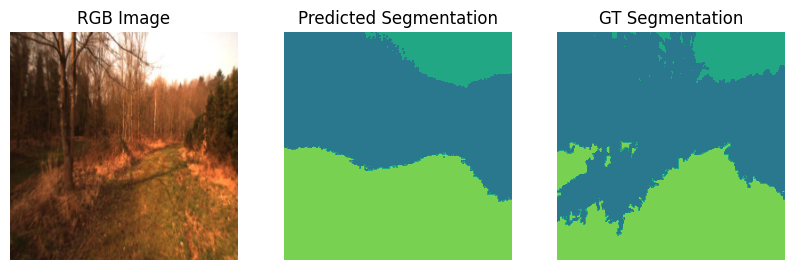

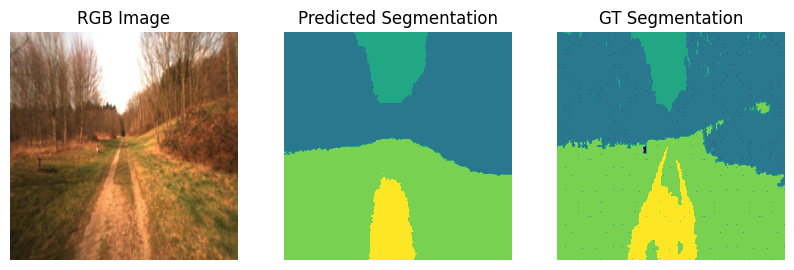

In [9]:
test_loss, test_acc = model.evaluate(test_rgb, test_labels, verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

viridis = mpl.colormaps['viridis'].resampled(num_classes)

norm1 = colors.BoundaryNorm(range(num_classes+1), num_classes)

for i in range(5):
    idx = random.randint(0, len(test_rgb) - 1)
    rgb_sample = np.expand_dims(test_rgb[idx], axis=0)
    true_label = np.reshape(np.argmax(test_labels[idx], axis=-1),(256,256))
    pred_label =np.reshape(np.argmax(model.predict(rgb_sample, verbose=0)[0], axis=-1),(256,256))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(rgb_sample[0])
    plt.title('RGB Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(pred_label,cmap=viridis, norm=norm1)
    plt.title('Predicted Segmentation')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(true_label,cmap=viridis, norm=norm1)
    plt.title('GT Segmentation')
    plt.axis('off')
    plt.show()

In [10]:
# Define input shapes
depth_input_shape = (256, 256, 3)

# Define input layers
depth_input = tf.keras.Input(shape=depth_input_shape, name='depth_input')

# Define the ResNet50 layer for each stream


# Define the ResNet50 layer for each stream
base_resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')

depth_resnet = base_resnet(depth_input)

# rgb_resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', name='rgb_resnet')(rgb_input)
# depth_resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')(depth_input)

# Add two Conv layers with 128 and 256 nodes, respectively, to each stream
depth_conv1 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(depth_resnet)
depth_conv2 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(depth_conv1)

# Add dropout layers to each stream
depth_dropout = tf.keras.layers.Dropout(0.2)(depth_conv2)

# Concatenate the two streams
# concat = tf.keras.layers.Concatenate()([rgb_dropout, depth_dropout])

# Add a transposed convolution layer
transpose_conv = tf.keras.layers.Conv2DTranspose(6, kernel_size=(64, 64), strides=(32, 32), padding='same')(depth_dropout)

# Add a reshape layer
reshape = tf.keras.layers.Reshape((256*256,6))(transpose_conv)

# Add a softmax activation layer
output = tf.keras.layers.Softmax()(reshape)

# Define the model with two inputs and one output
model = tf.keras.models.Model(inputs=depth_input, outputs=output)

In [11]:
model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.008, decay=1e-6, momentum=0.9),
              loss="categorical_crossentropy", metrics=['accuracy'])

# Train the model on the training data
history = model.fit(train_depth, train_labels, batch_size=2, epochs=10,
                    validation_data=(val_depth, val_labels))

Epoch 1/10


2023-03-20 16:17:14.919929: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 9s 54ms/step - loss: 1.3896 - accuracy: 0.4422 - val_loss: 1.0510 - val_accuracy: 0.5920
Epoch 2/10
100/100 [==============================] - 4s 45ms/step - loss: 0.7757 - accuracy: 0.7122 - val_loss: 0.7198 - val_accuracy: 0.7316
Epoch 3/10
100/100 [==============================] - 4s 45ms/step - loss: 0.5604 - accuracy: 0.7768 - val_loss: 0.6824 - val_accuracy: 0.7283
Epoch 4/10
100/100 [==============================] - 4s 45ms/step - loss: 0.4705 - accuracy: 0.8209 - val_loss: 0.5280 - val_accuracy: 0.7987
Epoch 5/10
100/100 [==============================] - 4s 45ms/step - loss: 0.3948 - accuracy: 0.8530 - val_loss: 0.5015 - val_accuracy: 0.8061
Epoch 6/10
100/100 [==============================] - 4s 45ms/step - loss: 0.3599 - accuracy: 0.8662 - val_loss: 0.4254 - val_accuracy: 0.8383
Epoch 7/10
100/100 [==============================] - 5s 45ms/step - loss: 0.3210 - accuracy: 0.8812 - val_loss: 0.4319 - val_accuracy: 0.8382
Epoch 8/10

4/4 - 1s - loss: 0.3935 - accuracy: 0.8607 - 1s/epoch - 257ms/step
Test loss: 0.39354178309440613
Test accuracy: 0.8606700301170349


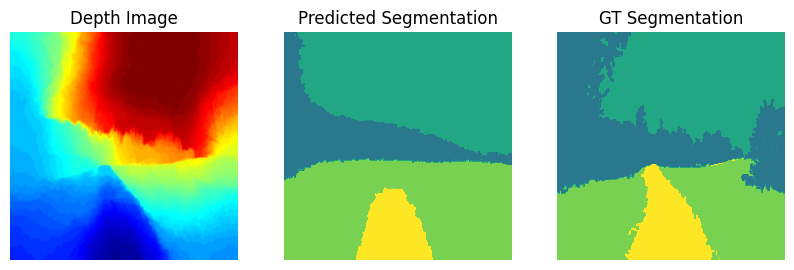

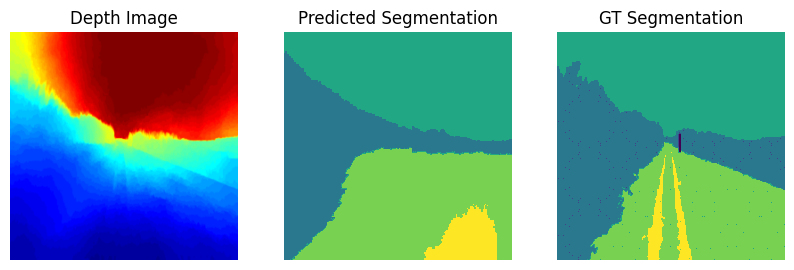

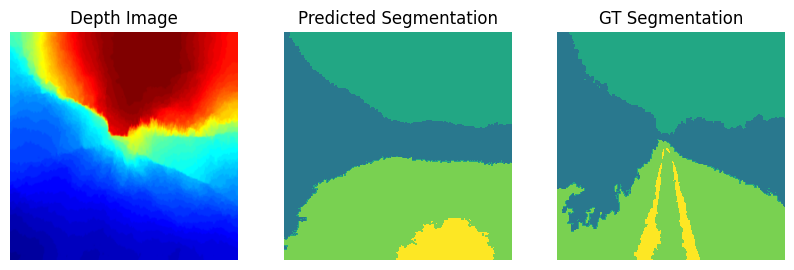

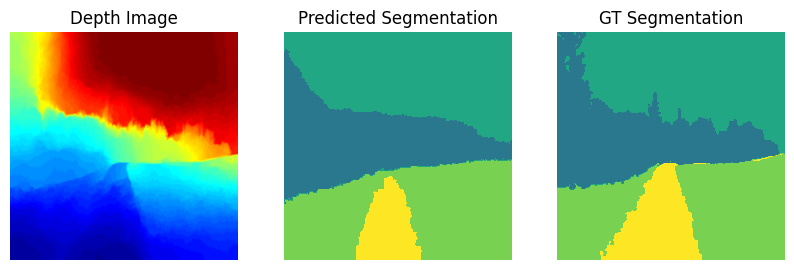

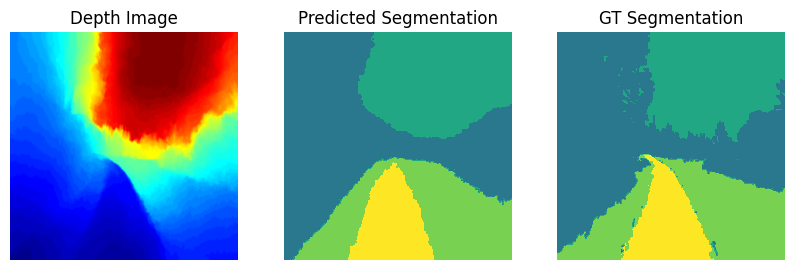

In [12]:
test_loss, test_acc = model.evaluate(test_depth, test_labels, verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

viridis = mpl.colormaps['viridis'].resampled(num_classes)

norm1 = colors.BoundaryNorm(range(num_classes+1), num_classes)

for i in range(5):
    idx = random.randint(0, len(test_depth) - 1)
    depth_sample = np.expand_dims(test_depth[idx], axis=0)
    true_label = np.reshape(np.argmax(test_labels[idx], axis=-1),(256,256))
    pred_label =np.reshape(np.argmax(model.predict(depth_sample, verbose=0)[0], axis=-1),(256,256))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(depth_sample[0], cmap='gray')
    plt.title('Depth Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(pred_label,cmap=viridis, norm=norm1)
    plt.title('Predicted Segmentation')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(true_label,cmap=viridis, norm=norm1)
    plt.title('GT Segmentation')
    plt.axis('off')
    plt.show()

# RESULT

| **Modality** | **Test Accuracy(%)** |
| -------- | -------- |
| RGB only | **90.89%** |
| Depth Only | 86.06% |
| RBB and Depth Fusion | 87.46% |